# Analiza eksploracyjna danych

### Wczytanie bibliotek oraz danych:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import seaborn as sns
from scipy import interpolate
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\agata\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
Power_curve = pd.read_csv('data/train/Power_curve.csv').set_index('Wind speed (m/s)')
signals = pd.read_csv('data/train/wind-farm-1-signals-training.csv', sep=';', parse_dates=['Timestamp'])
# Podział na zbiory dla każdej z turbin osobno, indeks czasowy
signals_T01 = signals[signals.Turbine_ID=='T01'].set_index('Timestamp')
signals_T06 = signals[signals.Turbine_ID=='T06'].set_index('Timestamp')
signals_T07 = signals[signals.Turbine_ID=='T07'].set_index('Timestamp')
signals_T09 = signals[signals.Turbine_ID=='T09'].set_index('Timestamp')
signals_T11 = signals[signals.Turbine_ID=='T11'].set_index('Timestamp')

## Power curve

Teoretyczna zależność generowanej mocy prądu od prędkości wiatru.

 * cut-in wind speed: 4m/s (żółta linia)
 * cut-out wind speed: 25m/s (zielona linia)

Krzywa power curve:

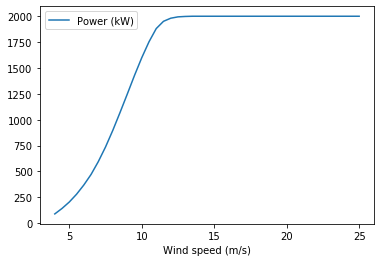

In [3]:
Power_curve.plot()
plt.show()

Porównanie teoretycznej krzywej oraz rzeczywistych danych z turbin:

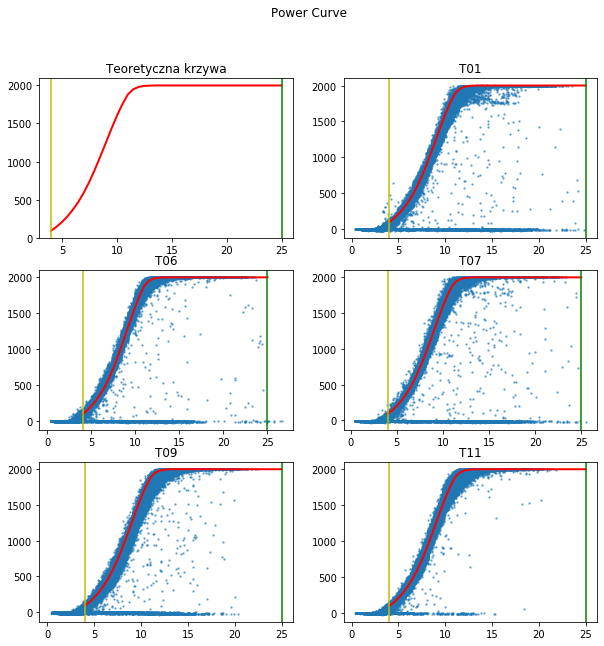

In [4]:
fig, ax = plt.subplots(3,2, figsize=(10,10))
fig.suptitle('Power Curve')
ax[0,0].plot(Power_curve, c='r', linewidth=2)
ax[0,0].set_title('Teoretyczna krzywa')
ax[0,0].axvline(4, c="y")
ax[0,0].axvline(25, c="g")

ax[0,1].scatter('Amb_WindSpeed_Avg', 'Grd_Prod_Pwr_Avg', data=signals_T01, s=2, alpha=0.5)
ax[0,1].plot(Power_curve, c='r', linewidth=2)
ax[0,1].set_title('T01')
ax[0,1].axvline(4, c="y")
ax[0,1].axvline(25, c="g")

ax[1,0].scatter('Amb_WindSpeed_Avg', 'Grd_Prod_Pwr_Avg', data=signals_T06, s=2, alpha=0.5)
ax[1,0].plot(Power_curve, c='r', linewidth=2)
ax[1,0].set_title('T06')
ax[1,0].axvline(4, c="y")
ax[1,0].axvline(25, c="g")

ax[1,1].scatter('Amb_WindSpeed_Avg', 'Grd_Prod_Pwr_Avg', data=signals_T07, s=2, alpha=0.5)
ax[1,1].plot(Power_curve, c='r', linewidth=2)
ax[1,1].set_title('T07')
ax[1,1].axvline(4, c="y")
ax[1,1].axvline(25, c="g")

ax[2,0].scatter('Amb_WindSpeed_Avg', 'Grd_Prod_Pwr_Avg', data=signals_T09, s=2, alpha=0.5)
ax[2,0].plot(Power_curve, c='r', linewidth=2)
ax[2,0].set_title('T09')
ax[2,0].axvline(4, c="y")
ax[2,0].axvline(25, c="g")

ax[2,1].scatter('Amb_WindSpeed_Avg', 'Grd_Prod_Pwr_Avg', data=signals_T11, s=2, alpha=0.5)
ax[2,1].plot(Power_curve, c='r', linewidth=2)
ax[2,1].set_title('T11')
ax[2,1].axvline(4, c="y")
ax[2,1].axvline(25, c="g")

plt.show()

### Czyszczenie danych


In [5]:
# Odrzucenie ujemnych wartości generowanego prądu
def maintain_positive(turbine):
    return turbine.loc[turbine["Grd_Prod_Pwr_Avg"] > 0, :]

signals_T01 = maintain_positive(signals_T01)
signals_T06 = maintain_positive(signals_T06)
signals_T07 = maintain_positive(signals_T07)
signals_T09 = maintain_positive(signals_T09)
signals_T11 = maintain_positive(signals_T11)

In [6]:
# Funkcja przycina dane do prędkości wiatru z zakresu [lower,uper]
def trim_wind(turbine, lower, uper):
    return turbine.loc[(turbine["Amb_WindSpeed_Avg"] < uper) & (turbine["Amb_WindSpeed_Avg"] > lower) , :]

## Różne metody standaryzacji mocy prądu według power curve

### Standaryzacja 1.

Ciągłe przybliżenie power curve za pomocą interpolacji liniowej.

In [7]:
# Interpolacja liniowa względem Power_curve (działa dla wiatrów 4-25)
power_curve1 = interpolate.interp1d(Power_curve.index, Power_curve.iloc[:,0])

In [8]:
def std_power_curve1(turbine):
    turbine_new = turbine.copy()
    turbine_new = trim_wind(turbine, 4, 15)
    turbine_new.loc[:,"Pwr_Std"] = turbine_new.loc[:,"Grd_Prod_Pwr_Avg"] - power_curve1(turbine_new.loc[:,"Amb_WindSpeed_Avg"])
    return turbine_new

signals_T01_std = std_power_curve1(signals_T01)
signals_T06_std = std_power_curve1(signals_T06)
signals_T07_std = std_power_curve1(signals_T07)
signals_T09_std = std_power_curve1(signals_T09)
signals_T11_std = std_power_curve1(signals_T11)

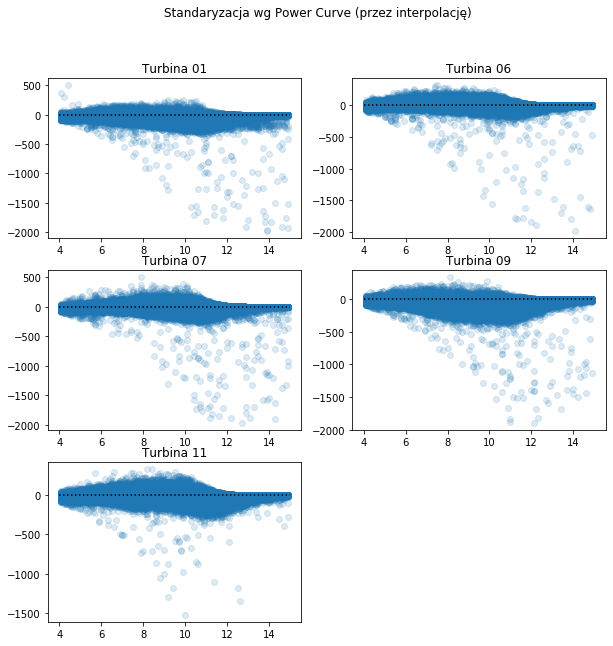

In [9]:
fig, ax = plt.subplots(3,2, figsize=(10,10))
fig.suptitle('Standaryzacja wg Power Curve (przez interpolację)')

ax[0,0].scatter(signals_T01_std.Amb_WindSpeed_Avg, signals_T01_std.Pwr_Std, alpha=0.15)
ax[0,0].set_title("Turbina 01")
ax[0,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[0,1].scatter(signals_T06_std.Amb_WindSpeed_Avg, signals_T06_std.Pwr_Std, alpha=0.15)
ax[0,1].set_title("Turbina 06")
ax[0,1].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[1,0].scatter(signals_T07_std.Amb_WindSpeed_Avg, signals_T07_std.Pwr_Std, alpha=0.15)
ax[1,0].set_title("Turbina 07")
ax[1,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[1,1].scatter(signals_T09_std.Amb_WindSpeed_Avg, signals_T09_std.Pwr_Std, alpha=0.15)
ax[1,1].set_title("Turbina 09")
ax[1,1].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[2,0].scatter(signals_T11_std.Amb_WindSpeed_Avg, signals_T11_std.Pwr_Std, alpha=0.15)
ax[2,0].set_title("Turbina 11")
ax[2,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[2,1].set_axis_off()
plt.show()

### Standaryzacja 2. 

Ciągłe przybliżenie power curve za pomocą funkcji sigmoidalnej.

Funkcja sigmoidalna to funkcja postaci $$y(x)=L/(1 + e^{-k (x - x_0)}) + b,$$ gdzie $L$, $k$, $x_0$ oraz $b$ są parametrami.

In [10]:
# Funkcja sigmoidalna:
def sigmoid_curve(x, L, x_0, k, b):
    return L / (1 + np.exp(-k * (x - x_0))) + b

x_data = Power_curve.index
y_data = Power_curve.iloc[:, 0]

# Estymacja parametrów L, x_0, k, b:
init_state = [max(y_data), np.median(x_data), 1, min(y_data)]
popt, pcov = curve_fit(sigmoid_curve, x_data, y_data, method="dogbox")
popt

array([1.91136823e+03, 8.37590241e+00, 8.37235051e-01, 9.92345945e+01])

In [11]:
# Sigmoidalne przybliżenie 
def power_curve2(x):
    return 1911.36823 / (1 + np.exp(-0.83735044 * (x - 8.3759024))) + 99.92345886

def std_power_curve2(turbine):
    turbine_new = turbine.copy()
    turbine_new = trim_wind(turbine, 4, 15)
    turbine_new.loc[:,"Pwr_Sigm"] = turbine_new.loc[:,"Grd_Prod_Pwr_Avg"] - power_curve2(turbine_new.loc[:,"Amb_WindSpeed_Avg"])
    return turbine_new

signals_T01_std = std_power_curve2(signals_T01_std)
signals_T06_std = std_power_curve2(signals_T06_std)
signals_T07_std = std_power_curve2(signals_T07_std)
signals_T09_std = std_power_curve2(signals_T09_std)
signals_T11_std = std_power_curve2(signals_T11_std)

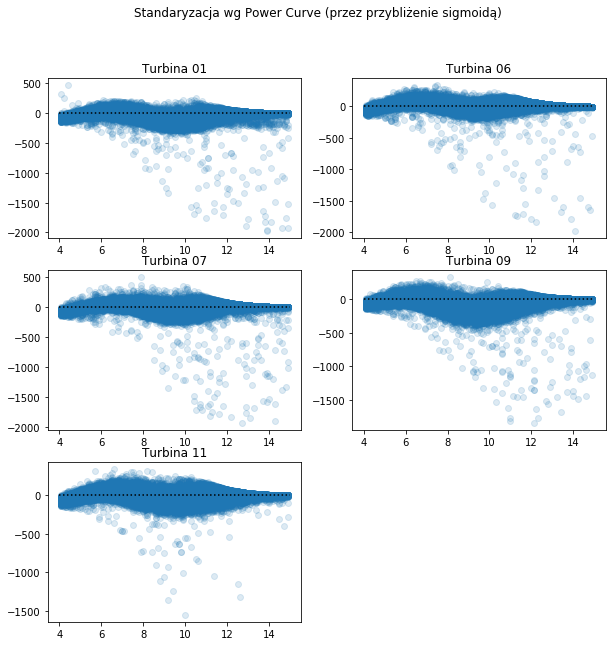

In [12]:
fig, ax = plt.subplots(3,2, figsize=(10,10))
fig.suptitle('Standaryzacja wg Power Curve (przez przybliżenie sigmoidą)')

ax[0,0].scatter(signals_T01_std.Amb_WindSpeed_Avg, signals_T01_std.Pwr_Sigm, alpha=0.15)
ax[0,0].set_title("Turbina 01")
ax[0,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[0,1].scatter(signals_T06_std.Amb_WindSpeed_Avg, signals_T06_std.Pwr_Sigm, alpha=0.15)
ax[0,1].set_title("Turbina 06")
ax[0,1].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[1,0].scatter(signals_T07_std.Amb_WindSpeed_Avg, signals_T07_std.Pwr_Sigm, alpha=0.15)
ax[1,0].set_title("Turbina 07")
ax[1,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[1,1].scatter(signals_T09_std.Amb_WindSpeed_Avg, signals_T09_std.Pwr_Sigm, alpha=0.15)
ax[1,1].set_title("Turbina 09")
ax[1,1].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[2,0].scatter(signals_T11_std.Amb_WindSpeed_Avg, signals_T11_std.Pwr_Sigm, alpha=0.15)
ax[2,0].set_title("Turbina 11")
ax[2,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[2,1].set_axis_off()
plt.show()

Porównanie przybliżeń za pomocą sigmoidy oraz interpolacji liniowej

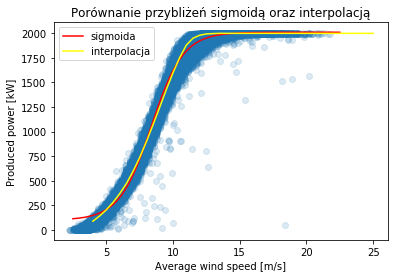

In [13]:
plt.scatter(signals_T11.Amb_WindSpeed_Avg, signals_T11.Grd_Prod_Pwr_Avg, alpha=0.15)
plt.plot(np.linspace(2.5, 22.5, 1000), power_curve2(np.linspace(2.5, 22.5, 1000)), color="red", label="sigmoida")
plt.plot(Power_curve, color='yellow', label="interpolacja")
plt.xlabel("Average wind speed [m/s]")
plt.ylabel("Produced power [kW]")
plt.title("Porównanie przybliżeń sigmoidą oraz interpolacją")
plt.legend()
plt.show()

### Standaryzacja 3.

Standaryzacja opisana jest wzorem $$\text{Pwr_std}=1-\text{Pwr_Gen}/\text{Pwr_Theo},$$ gdzie $\text{Pwr_Gen}$ to generowany prąd, a $\text{Pwr_Theo}$ to teoretyczna wartość prądu dla tej samej prędkości wiatru. Przy takiej standaryzacji wartości bliskie 0 oznaczają idealną pracę zgodną z teoretyczną krzywą, wartości dodatnie oznaczają pracą gorszą niż teoretyczna (mniejszy generowany prąd), a wartości ujemne pracę lepszą niż teoretyczna (większy generowany prąd).

In [14]:
def std_power_curve3(turbine):
    turbine_new = turbine.copy()
    turbine_new = trim_wind(turbine, 4, 15)
    turbine_new.loc[:,"Pwr_Ratio"] = 1 - (turbine_new.loc[:,"Grd_Prod_Pwr_Avg"] / power_curve1(turbine_new.loc[:,"Amb_WindSpeed_Avg"]))
    return turbine_new

signals_T01_std = std_power_curve3(signals_T01_std)
signals_T06_std = std_power_curve3(signals_T06_std)
signals_T07_std = std_power_curve3(signals_T07_std)
signals_T09_std = std_power_curve3(signals_T09_std)
signals_T11_std = std_power_curve3(signals_T11_std)

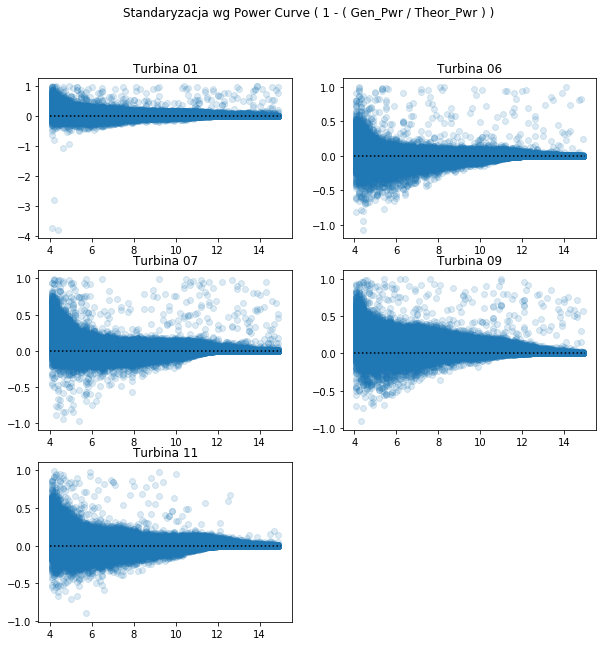

In [15]:
fig, ax = plt.subplots(3,2, figsize=(10,10))
fig.suptitle('Standaryzacja wg Power Curve ( 1 - ( Gen_Pwr / Theor_Pwr ) )')

ax[0,0].scatter(signals_T01_std.Amb_WindSpeed_Avg, signals_T01_std.Pwr_Ratio, alpha=0.15)
ax[0,0].set_title("Turbina 01")
ax[0,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[0,1].scatter(signals_T06_std.Amb_WindSpeed_Avg, signals_T06_std.Pwr_Ratio, alpha=0.15)
ax[0,1].set_title("Turbina 06")
ax[0,1].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[1,0].scatter(signals_T07_std.Amb_WindSpeed_Avg, signals_T07_std.Pwr_Ratio, alpha=0.15)
ax[1,0].set_title("Turbina 07")
ax[1,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[1,1].scatter(signals_T09_std.Amb_WindSpeed_Avg, signals_T09_std.Pwr_Ratio, alpha=0.15)
ax[1,1].set_title("Turbina 09")
ax[1,1].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[2,0].scatter(signals_T11_std.Amb_WindSpeed_Avg, signals_T11_std.Pwr_Ratio, alpha=0.15)
ax[2,0].set_title("Turbina 11")
ax[2,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[2,1].set_axis_off()
plt.show()

## Warunki zewnętrzne pracy turbin

In [16]:
signals = signals.set_index("Timestamp")

In [17]:
ambient = signals.loc[:,['Amb_WindSpeed_Avg','Amb_Temp_Avg']].groupby([(signals.index.year),(signals.index.month)]).mean()
max_wind = signals.loc[:,'Amb_WindSpeed_Max'].groupby([(signals.index.year),(signals.index.month)]).max()

Średnia prędkość wiatru (w miesiącu)

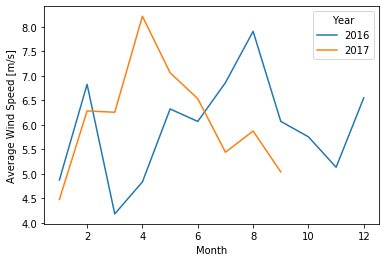

In [18]:
ambient.unstack(level=0).Amb_WindSpeed_Avg.plot()
plt.xlabel("Month")
plt.ylabel("Average Wind Speed [m/s]")
plt.legend(title="Year")

Maksymalna prędkość wiatru (w miesiącu)

In [19]:
max_wind[-1] = np.NaN 
# dla ostatniego miesiąca (sierpień 2017) jest tylko jedna obserwacja z godziny 00:00,
# usuwamy ją ponieważ znacznie odstaje od pozostałych temperatur i zaburza wykres

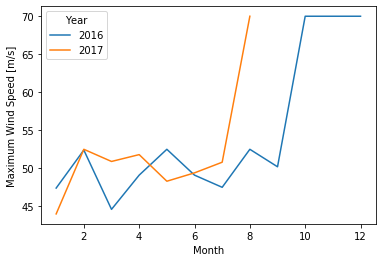

In [20]:
max_wind.unstack(level=0).plot()
plt.xlabel("Month")
plt.ylabel("Maximum Wind Speed [m/s]")
plt.legend(title="Year")

Średnia temperatura (w miesiącu)

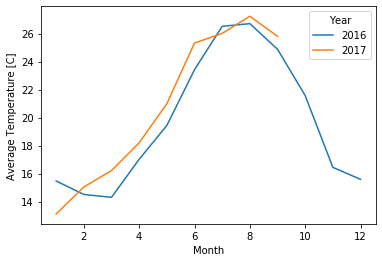

In [21]:
ambient.unstack(level=0).Amb_Temp_Avg.plot()
plt.xlabel("Month")
plt.ylabel("Average Temperature [C]")
plt.legend(title="Year")

## Nałożenie na dane momentów awarii

W tym kroku dodajemy kolumnę 'failure' do danych dla każdej turbiny. W zależności od dobranego parametru będzie ona obejmowała $p$-timestampów wstecz, przed awarią. Wartości w tej kolumnie będą się zmniejszały od $p$-tego rekordu aż do $1$ w rekordzie, w którym wystąpiła awaria. Jeżeli w danym momencie nie było awarii, ani nie poprzedzał on żadnej, to wartości ustawiamy na zero.

Zbiór 'failures' został uprzednio przekształcony. Kolumna 'Timestamp' zawierała dokładną godzinę wystąpienia awarii (co do minuty). Wartości te zaokrąglamy w dół z dokładnością do 10 minut, aby pokrywały się z danymi z turbin.

In [22]:
failures = pd.read_csv("data/train/wind-farm-1-failures-training.csv", sep=';')
failures.Timestamp = pd.to_datetime(failures.Timestamp)
failures.Timestamp = failures.Timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, 10 * math.floor(dt.minute / 10), dt.second))

In [23]:
signals_T01["Timestamp_Datetime"] = pd.to_datetime(signals_T01.index)
signals_T06["Timestamp_Datetime"] = pd.to_datetime(signals_T06.index)
signals_T07["Timestamp_Datetime"] = pd.to_datetime(signals_T07.index)
signals_T09["Timestamp_Datetime"] = pd.to_datetime(signals_T09.index)
signals_T11["Timestamp_Datetime"] = pd.to_datetime(signals_T11.index)
signals_T01.Timestamp_Datetime = signals_T01.Timestamp_Datetime.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second))
signals_T06.Timestamp_Datetime = signals_T06.Timestamp_Datetime.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second))
signals_T07.Timestamp_Datetime = signals_T07.Timestamp_Datetime.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second))
signals_T09.Timestamp_Datetime = signals_T09.Timestamp_Datetime.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second))
signals_T11.Timestamp_Datetime = signals_T11.Timestamp_Datetime.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second))


In [24]:
def mark_failures(turbine, p=4):
    turbineID = turbine.iloc[0, 0]
    times = failures.loc[failures.Turbine_ID == turbineID, "Timestamp"]
    turbine["Failure"] = np.zeros(len(turbine), dtype=int)
    for t in times:
        index = np.array(turbine.Timestamp_Datetime <= t)
        # Zastawiamy jedynie ostanie 'p' wartości True
        failures_index = np.where(index)[0][-p:]
        index = np.array([False] * len(index))
        index[failures_index] = True
        turbine.loc[index, "Failure"] = np.linspace(p, 1, num=p, endpoint=True, dtype=int)

In [25]:
mark_failures(signals_T01)
mark_failures(signals_T06)
mark_failures(signals_T07)
mark_failures(signals_T09)
mark_failures(signals_T11)

In [26]:
def power_curve_with_fails(turbine):
    no_fails = (turbine.Failure == 0)
    fails = (turbine.Failure != 0)
    ax = sns.scatterplot(data=turbine.loc[no_fails, :], x="Amb_WindSpeed_Avg", y="Grd_Prod_Pwr_Avg", color="lightblue", alpha = 0.21, legend=False,linewidth=0)
    sns.scatterplot(data=turbine.loc[fails, :], x="Amb_WindSpeed_Avg", y="Grd_Prod_Pwr_Avg", hue="Failure", ax=ax, 
                    palette="mako", linewidth=0, alpha=0.75, legend=False)

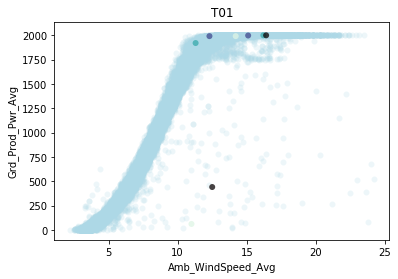

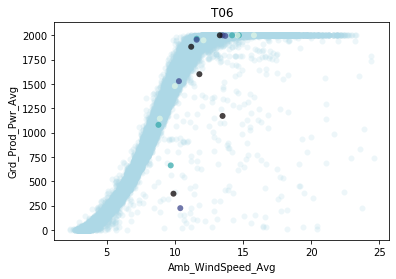

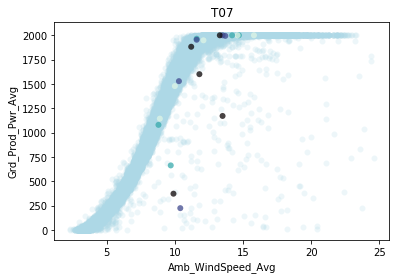

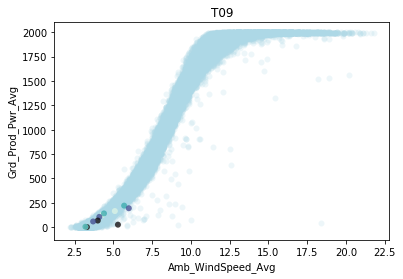

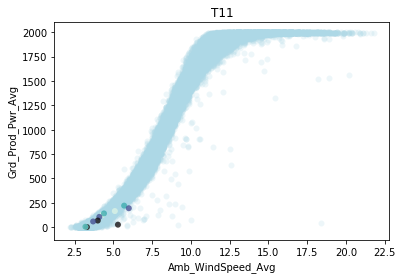

In [27]:
plt.figure() # creates a figure
power_curve_with_fails(signals_T01)
plt.title("T01")

plt.figure() # creates a new figure
power_curve_with_fails(signals_T07)
plt.title("T06")

plt.figure() # creates a new figure
power_curve_with_fails(signals_T07)
plt.title("T07")

plt.figure() # creates a figure
power_curve_with_fails(signals_T11)
plt.title("T09")

plt.figure() # creates a figure
power_curve_with_fails(signals_T11)
plt.title("T11")

plt.show()